In [ ]:
! rm -rf DL-models-experiments/
! git clone https://github.com/einstalek/DL-models-experiments.git

In [ ]:
import sys
sys.path.append("./DL-models-experiments/")

from models.retinanet import RetinaNet
from datasets.utils import encode_batch, parse_xml
from datasets.cat_dog_dataset_boxes import CatDogDataset
from utils.visual import plot_bbox
from models.retinanet import train_single_epoch, evaluale_single_epoch

In [108]:
import os
import random
import torch
import torch.nn as nn
from torchvision import ops
from torch.utils.data import DataLoader
import tqdm
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
XML_ROOT = "../input/dog-and-cat-detection/annotations/"
IMG_ROOT = "../input/dog-and-cat-detection/images/"

fps = [x for x in os.listdir(XML_ROOT) if '.xml' in x]
TRAIN, TEST = train_test_split(fps, test_size=0.1, random_state=1)

In [ ]:
train_data = CatDogDataset(XML_ROOT, IMG_ROOT, TRAIN, split="train", mixup=False)
train_loader = DataLoader(train_data, 16, drop_last=True, shuffle=True, num_workers=8)
test_data = CatDogDataset(XML_ROOT, IMG_ROOT, TEST, split="val")
test_loader = DataLoader(test_data, 8, shuffle=False, drop_last=True, num_workers=8)

retina = RetinaNet(pretrained=True)
retina = retina.cuda()
anchors = retina.anchors = retina.anchors.cuda()

In [384]:
retina.regr_weightr = 10.

In [385]:
from losses.losses import FocalLoss
focal_loss = FocalLoss(reduction='sum', high_conf_reg=1e-4)
l1_loss = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(retina.parameters(), 5e-5)

In [383]:
def train_single_epoch(model: RetinaNet, optimizer, dataloader,
                       cls_crit, reg_crit, epoch, clip_grad_norm=None,
                       postfix_dict={}, device="cpu"):
    model.train()
    anchors = model.anchors
    total_step = len(dataloader)
    total_loss = 0
    tbar = tqdm.tqdm(enumerate(dataloader), total=total_step, position=0, leave=True)
    for i, (images, boxes, labels) in tbar:
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)
        cls_target, reg_target = encode_batch(anchors, boxes, labels, 2)
        cls_target = cls_target.to(device)
        reg_target = reg_target.to(device)

        if (cls_target >= 0).sum(1).min() < 1:
            continue

        cls_out, reg_out = model(images)
        cls_loss = cls_crit(cls_out, cls_target)
        regr_loss = reg_crit(reg_out, reg_target) * (cls_target >= 0)
        regr_loss /= (cls_target >= 0).sum()
        regr_loss = regr_loss.sum()
        loss = model.cls_weight * cls_loss + model.regr_weight * regr_loss
        loss.backward()

        if clip_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)

        optimizer.step()
        total_loss += loss.item()
        postfix_dict['train/loss'] = loss.item()

        f_epoch = epoch + i / total_step
        desc = '{:5s}'.format('train')
        desc += ', {:06d}/{:06d}, {:.2f} epoch'.format(i, total_step, f_epoch)
        tbar.set_description(desc)
        tbar.set_postfix(**postfix_dict)
    postfix_dict['train/loss'] = total_loss / len(dataloader)

In [386]:
postfix_dict = {}
for i in range(20):
    train_single_epoch(retina, optimizer, train_loader, 
                       focal_loss, l1_loss, i, 1.,
                       postfix_dict, device="cuda")
    evaluale_single_epoch(retina, test_loader, 
                          focal_loss, l1_loss, i, 
                          postfix_dict, 5, device="cuda")

train, 000037/000207, 18.18 epoch:  18%|█▊        | 38/207 [00:15<01:11,  2.38it/s, train/loss=8.64, val/iou=0.288, val/loss=11.4]


KeyboardInterrupt: 

In [80]:
def inference(boxes, labels, conf):
    """
    Returns:
        -- weighted average box
        -- weighted probability of class == 1
        -- int class label
    """
    _conf = conf.detach().cpu().numpy()[..., None]
    _labels = labels.detach().cpu().numpy()
    _boxes = boxes.detach().cpu().numpy()
    avg_boxes = (_boxes * _conf).sum(0) / _conf.sum()
    return avg_boxes, _conf[0, 0], _labels[0]

In [387]:
data = CatDogDataset(XML_ROOT, IMG_ROOT, TEST, shape=(256, 256), split='val')

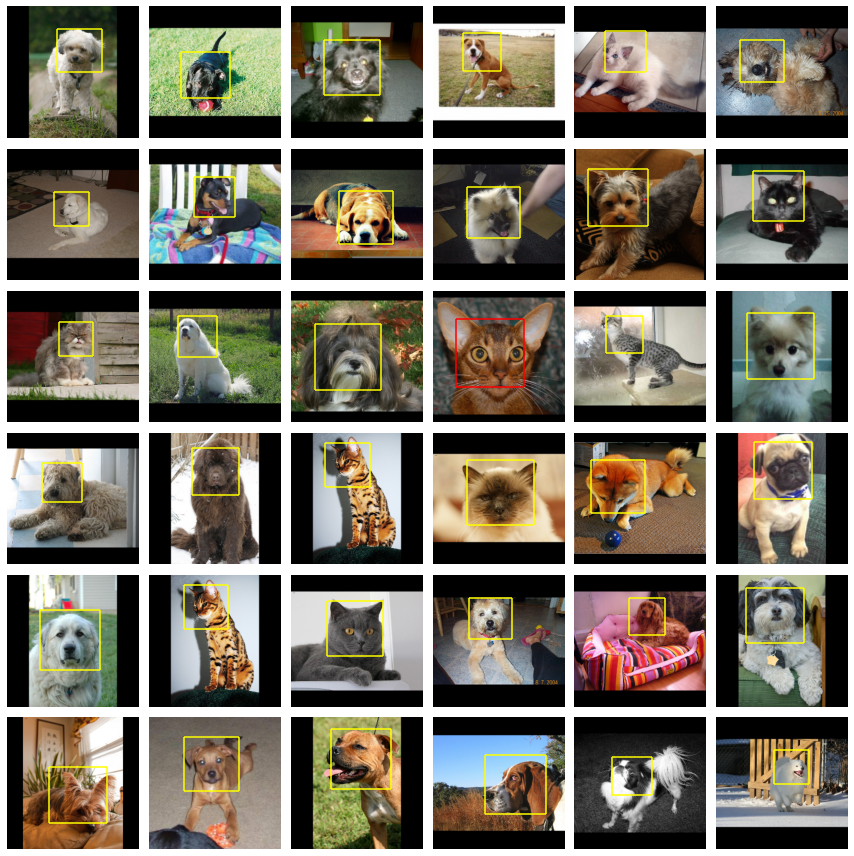

In [389]:
plt.figure(figsize=(12, 12))

random.seed(10)
ids = []
for i in range(36):
    idx = random.randint(0, len(data)-1)
    x, _, gt = data[idx]
    ids.append(idx)
    cls_out, regr_out = retina(x[None].cuda())
    pred_boxes, pred_labels, conf = retina.inference(cls_out, regr_out, min_conf=0.3, k=5)
    box, proba, cl = inference(pred_boxes[0], pred_labels[0], conf[0])
    img = 0.5 + 0.5 * x.detach().numpy().transpose(1, 2, 0)
    plt.subplot(6, 6, i+1)
    plt.imshow(img)
    color = 'yellow' if cl == int(gt) else 'red'
    plot_bbox(box, mode="cxcywh", c=color)
    plt.axis('off')
plt.tight_layout()

In [132]:
! git clone https://github.com/Cartucho/mAP

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 31.51 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [390]:
! rm ./mAP/input/detection-results/*
! rm ./mAP/input/ground-truth/*
! rm ./mAP/input/images-optional/*

rm: cannot remove './mAP/input/detection-results/*': No such file or directory
rm: cannot remove './mAP/input/ground-truth/*': No such file or directory
rm: cannot remove './mAP/input/images-optional/*': No such file or directory


In [391]:
def preprocess_image(img, bbox, shape=(256, 256)):
    pad_h, pad_w = 0, 0
    h, w, _ = img.shape
    if h > w:
        pad = int((h - w) / 2)
        pad_w = pad
        img = np.pad(img, ((0,  0), (pad, pad), (0, 0)))
    else:
        pad = int((w - h) / 2)
        pad_h = pad
        img = np.pad(img, ((pad, pad), (0,  0), (0, 0)))
    h, w, _ = img.shape
    img = cv2.resize(img, shape)
    H, W, _ = img.shape
    scale_x, scale_y = w / W, h / H
    x1, y1, x2, y2 = bbox
    x1, x2 = (x1 + pad_w) / scale_x, (x2 + pad_w) / scale_x
    y1, y2 = (y1 + pad_h) / scale_y, (y2 + pad_h) / scale_y
    return (pad_h, pad_w), (scale_x, scale_y)


def load_sample(xml_fp):
    obj = parse_xml(os.path.join(XML_ROOT, xml_fp))
    img_fp = os.path.join(IMG_ROOT, obj['filename'])
    assert os.path.exists(img_fp)
    img = cv2.imread(img_fp)
    return obj, img[..., ::-1]

In [392]:
for i, (x, _, _) in tqdm.tqdm(enumerate(data), leave=False, position=0):
    xml_fp = data.xml_fps[i]
    cls_out, regr_out = retina(x[None].cuda())
    pred_boxes, pred_labels, conf = retina.inference(cls_out, regr_out, min_conf=0.3, k=5)
    if len(conf[0]) == 0:
        continue

    box, proba, cl = inference(pred_boxes[0], pred_labels[0], conf[0])
    ann, img = load_sample(xml_fp)
    (pad_h, pad_w), (scale_x, scale_y) = preprocess_image(img, ann['bbox'])
    cx, cy, w, h = box
    x1, y1 = cx - w/2, cy - h/2
    x2, y2 = x1 + w, y1 + h
    x1 *= scale_x
    x2 *= scale_x
    y1 *= scale_y
    y2 *= scale_y
    y1 -= pad_h
    y2 -= pad_h
    x1 -= pad_w
    x2 -= pad_w
    
    fp = xml_fp.split('.')[0] + '.txt'
    with open(os.path.join("./mAP/input/detection-results", fp), "w") as f:
        cl = "cat" if cl == 0 else "dog"
        f.write("{} {} {} {} {} {}\n".format(cl, proba, x1, y1, x2, y2))
    with open(os.path.join("./mAP/input/ground-truth", fp), "w") as f:
        x1, y1, x2, y2 = ann['bbox']
        f.write("{} {} {} {} {}\n".format(ann['name'], x1, y1, x2, y2))

In [340]:
! python ./mAP/scripts/extra/intersect-gt-and-dr.py

total ground-truth files: 369
total detection-results files: 369

No backup required for /kaggle/working/mAP/input/ground-truth
No backup required for /kaggle/working/mAP/input/detection-results
total intersected files: 369
Intersection completed!


In [346]:
! python mAP/main.py

46.38% = cat AP 
68.65% = dog AP 
mAP = 57.52%
